In [ ]:
#FIXME: this notebook does not work with the papermill script yet, it throws an error because it does not find parquet files#
#this notebook is supposed to be run using the papermill script 2_run_iterative_notebook2.py#

from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly.subplots as sp
import math

from plotly.subplots import make_subplots
from scipy.stats import mode
from scipy.integrate import cumulative_trapezoid
from scipy.signal import correlate
import json
%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

import gc # garbage collector for removing large variables from memory instantly 
import importlib #for force updating changed packages 

#import harp
import harp_resources.process
import harp_resources.utils
from harp_resources import process, utils # Reassign to maintain direct references for force updating 
#from sleap import load_and_process as lp
import papermill as pm



In [ ]:
# IMPORTANT: Make sure this cell has the "parameters" tag in the Jupyter notebook
# In Jupyter: View -> Cell Toolbar -> Tags -> Add "parameters" tag to this cell

# Define default values (these will be overridden by papermill)
Data_path = None
Time_window_start = 1
Time_window_end = 1
Baseline_window = (-1, 0)
Plot_width = 1
Event_name = "Apply halt: 2s"
Vestibular_mismatch = False
Common_resampled_rate = 1
Plot_fig1 = False
Has_sleap = False

# Now convert the parameters to the variable names used in your notebook
data_path = Path(Data_path) if Data_path is not None else Path(".")
# data_path = Path('~/Desktop/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/downsampled_data/').expanduser()
time_window_start = Time_window_start
time_window_end = Time_window_end
baseline_window = Baseline_window
plot_width = Plot_width
event_name = Event_name
vestibular_mismatch = Vestibular_mismatch
common_resampled_rate = Common_resampled_rate
plot_fig1 = Plot_fig1
has_sleap = Has_sleap

# For debugging - print out to confirm parameters were received
print(f"Parameters received:")
print(f"data_path = {data_path}")
print(f"time_window_start = {time_window_start}")
print(f"time_window_end = {time_window_end}")
print(f"event_name = {event_name}")
print(f"has_sleap = {has_sleap}")

# For the loop issue, define a list with a single element
data_paths = [data_path]
idx = 1

Parameters received:
data_path = /home/ikharitonov/Desktop/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/downsampled_data
time_window_start = 1
time_window_end = 1
event_name = Apply halt: 2s
has_sleap = False


✅ Finished loading all parquet files
ℹ️ INFO: Found 4 events with name 'Apply halt: 2s' - not enough to calculate differences
ℹ️ Mousename: B6J2780
ℹ️ Unique events and their counts:
Event
Wait for run threshold...            8
Check halt probability               6
Halt delay: 0s                       4
Apply halt: 2s                       4
Block timer elapsed                  2
No halt                              2
Homing platform                      1
Sync signal started                  1
DrumWithReverseHalt block started    1
DrumBase block started               1
Name: count, dtype: int64
ℹ️ block events
                                                        Event  Time Difference
Time                                                                          
1904-01-01 21:27:25.110240             DrumBase block started              NaN
1904-01-01 21:32:25.430240                Block timer elapsed       300.320000
1904-01-01 21:32:25.440256  DrumWithReverseHalt block started  

time difference between photodiode and experimenet events:
min 61.6 ms. avg 77.6 ms. max 89.9 ms.


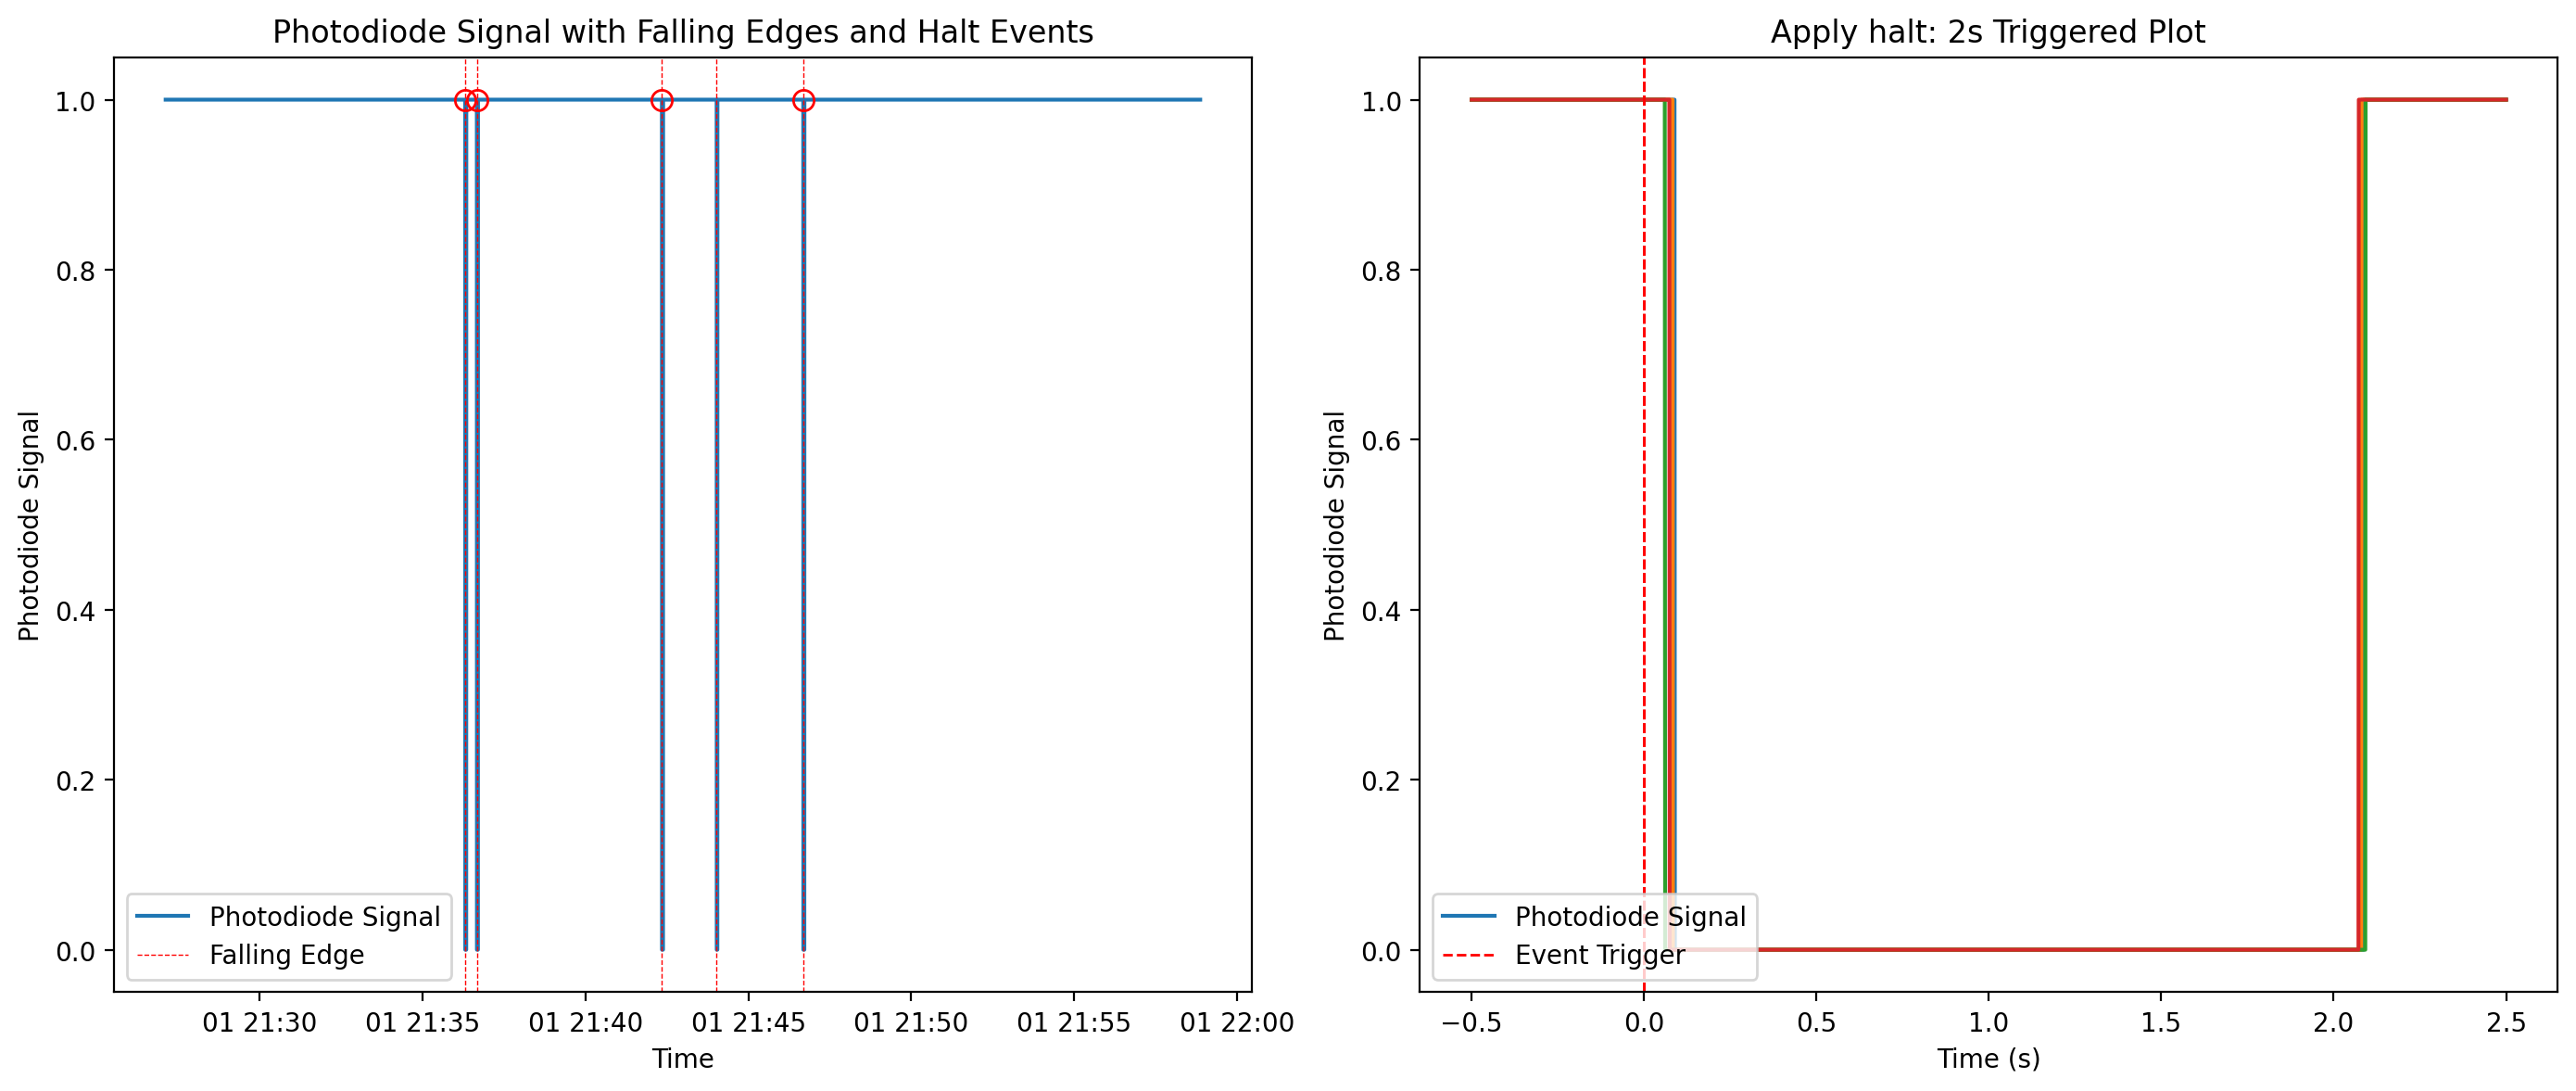

✅ 1 extra falling edges (outside 61.6ms - 89.9ms delay window) were removed before returning.
ℹ️ INFO: skipping figure 1

✅ Finished analyzing all 1 successfully processed data paths
Using time window: 1s to 1s relative to halt
Aligning 4 events for session 'B6J2780_downsampled_data'
✅ Saved aligned data to /home/ikharitonov/Desktop/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/aligned_data/B6J2780_downsampled_data_Apply halt: 2s_aligned.csv
✅ Saved figure to /home/ikharitonov/Desktop/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/B6J2780_downsampled_data_Apply halt: 2s.pdf

✅ Finished all data paths.
✅ Saved baseline-corrected figure to /home/ikharitonov/Desktop/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Visual_mismatch_day3/B6J2780-2025-04-25T11-51-53_processedData/aligned_data/B6J2780_downsampled_data_Apply halt: 2s_baseline_corrected.pdf


In [ ]:
#-------------------------------
# load downsampled data and save in dictionary
#-------------------------------
loaded_data = {}  # Dictionary to store loaded data for each path

photometry_tracking_encoder_data = pd.read_parquet(data_path / "photometry_tracking_encoder_data.parquet", engine="pyarrow")
camera_photodiode_data = pd.read_parquet(data_path / "camera_photodiode_data.parquet", engine="pyarrow")
experiment_events = pd.read_parquet(data_path / "experiment_events.parquet", engine="pyarrow")
photometry_info = pd.read_parquet(data_path / "photometry_info.parquet", engine="pyarrow")
session_settings = pd.read_parquet(data_path / "session_settings.parquet", engine="pyarrow")
session_settings["metadata"] = session_settings["metadata"].apply(process.safe_from_json)

print(f"✅ Finished loading all parquet files")

# Calculate time differences between event_name events

event_times = experiment_events[experiment_events["Event"] == event_name].index
if len(event_times) > 1:
    time_diffs = event_times.to_series().diff().dropna().dt.total_seconds()
            # Print the 5 shortest time differences
            # print("5 shortest time differences between events:")
            # print(time_diffs.nsmallest(5))
if (time_diffs < 10).any():
    print(f"⚠️ Warning: Some '{event_name}' events are less than 10 seconds apart. Consider applying a filter to events.")
else:
    print(f"ℹ️ INFO: Found {len(event_times)} events with name '{event_name}' - not enough to calculate differences")

mouse_name = process.check_exp_events(experiment_events, photometry_info, verbose = True)

# Store all loaded data in the dictionary
loaded_data[data_path] = {
    "photometry_tracking_encoder_data": photometry_tracking_encoder_data,
    "camera_photodiode_data": camera_photodiode_data,
    "experiment_events": experiment_events,
    "photometry_info": photometry_info,
    "session_settings": session_settings,
    "mouse_name": mouse_name
    }
#---------------------------------------------------
# create DFs and plot figure if True
#---------------------------------------------------

data_path_variables = {}

print(f"\n--------- Processing analysis for data path {idx}/{len(data_paths)}: {data_path} ---------")

# Load the data from the dictionary
photometry_tracking_encoder_data = loaded_data[data_path]["photometry_tracking_encoder_data"]
camera_photodiode_data = loaded_data[data_path]["camera_photodiode_data"]
experiment_events = loaded_data[data_path]["experiment_events"]
mouse_name = loaded_data[data_path]["mouse_name"]
session_name = f"{mouse_name}_{data_path.name}"  # Assuming session_name is constructed this way
      

df_to_analyze = photometry_tracking_encoder_data["Photodiode_int"] #using downsampled values in common time grid 
#df_to_analyze = camera_photodiode_data["Photodiode"] #use async raw values if needed for troubleshooting, but the nearest indices needs to be found , see couple of lines below

if vestibular_mismatch or event_name == "No halt": #determine halt times based on experiment events 
    photodiode_halts = experiment_events[experiment_events["Event"] == event_name].index.tolist()
    nearest_indices = photometry_tracking_encoder_data.index.get_indexer(photodiode_halts, method='nearest')
    photodiode_halts = photometry_tracking_encoder_data.index[nearest_indices] # as experiment events timestamps are not in the same time grid as downsampled data
    print ("ℹ️ INFO: vestibular MM or 'No halt', no signal in the photodiode, using experiment events for MM times")
    photodiode_delay_min = photodiode_delay_avg = photodiode_delay_max = None

else: #determine exact halt times based on photodiode signal
    photodiode_halts, photodiode_delay_min, photodiode_delay_avg, photodiode_delay_max = process.analyze_photodiode(df_to_analyze, experiment_events, event_name, plot = True)
# nearest_indices = photometry_tracking_encoder_data.index.get_indexer(photodiode_halts, method='nearest')
# photodiode_halts = photometry_tracking_encoder_data.index[nearest_indices]
if plot_fig1:
    process.plot_figure_1(photometry_tracking_encoder_data, session_name, save_path, common_resampled_rate, photodiode_halts, save_figure = True, show_figure = True, downsample_factor=50)
else: 
    print ("ℹ️ INFO: skipping figure 1")
del df_to_analyze
gc.collect()
None

# Store analysis results
data_path_variables[data_path] = {
    "photodiode_halts": photodiode_halts,
    "photodiode_delay_min": photodiode_delay_min,
    "photodiode_delay_avg": photodiode_delay_avg,
    "photodiode_delay_max": photodiode_delay_max,
    "session_name": session_name
}
# Define the selected indices
#selected_indices = [0, 1, 11, 16]
selected_indices = list(range(len(photodiode_halts)))

print(f"\n✅ Finished analyzing all {len(data_path_variables)} successfully processed data paths")

#---------------------------------------------------
# Create aligned data and plot comprehensive figures for each data path
#---------------------------------------------------

print(f"Using time window: {time_window_start}s to {time_window_end}s relative to halt")


# Extract data
data = loaded_data[data_path]
vars_ = data_path_variables[data_path]
        
df = data["photometry_tracking_encoder_data"]
halts = vars_["photodiode_halts"]
        
session_name = vars_.get("session_name")
if not session_name:
    mouse_name = data.get("mouse_name", "unknown_mouse")
    session_name = f"{mouse_name}_{data_path.stem}"
    print(f"⚠️ No session_name found, using: {session_name}")

event_name = event_name
print(f"Aligning {len(halts)} events for session '{session_name}'")

    # Align data to each halt event
aligned_data = []
for i, halt_time in enumerate(halts):
    window = df.loc[
        (df.index >= halt_time + pd.Timedelta(seconds=time_window_start)) &
        (df.index <= halt_time + pd.Timedelta(seconds=time_window_end))
    ].copy()

    if window.empty:
        print(f"⚠️ No data in window around halt {halt_time}")
        continue
    window["Time (s)"] = (window.index - halt_time).total_seconds()
    window["Halt Time"] = halt_time
    aligned_data.append(window)

if not aligned_data:
    print(f"⚠️ No aligned data generated for {session_name}, skipping")

aligned_df = pd.concat(aligned_data, ignore_index=True)

# Save CSV in same folder as data
aligned_dir = data_path.parent / "aligned_data"
aligned_dir.mkdir(exist_ok=True)

aligned_file = aligned_dir / f"{session_name}_{event_name}_aligned.csv"
aligned_df.to_csv(aligned_file, index=False)
print(f"✅ Saved aligned data to {aligned_file}")

# Compute mean and standard error of the mean (SEM)
mean_df = aligned_df.groupby("Time (s)").mean()
sem_df = aligned_df.groupby("Time (s)").sem()  

# Create figure for the two plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

## Plot 1: Individual Traces
ax1 = axes[0]
for halt in aligned_df["Halt Time"].unique():
    subset = aligned_df[aligned_df["Halt Time"] == halt]
    ax1.plot(subset["Time (s)"], subset["Photodiode_int"], color='grey', alpha=0.5)

ax1.set_title('Photodiode, z_470, and z_560')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Photodiode")

ax1_2 = ax1.twinx()
for halt in aligned_df["Halt Time"].unique():
    subset = aligned_df[aligned_df["Halt Time"] == halt]
    ax1_2.plot(subset["Time (s)"], subset["z_470"], color='green', alpha=0.5)
    ax1_2.plot(subset["Time (s)"], subset["z_560"], color='red', alpha=0.5)

ax1_2.set_ylabel("Fluorescence (z-score)", color='green')

## Plot 2: Mean + SEM
ax2 = axes[1]
ax2.plot(mean_df.index, mean_df["Photodiode_int"], color='grey')
ax2.fill_between(mean_df.index, mean_df["Photodiode_int"] - sem_df["Photodiode_int"],
                         mean_df["Photodiode_int"] + sem_df["Photodiode_int"], color='grey', alpha=0.2)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Photodiode")
ax2.set_title("Mean & SEM")

ax2_2 = ax2.twinx()
ax2_2.plot(mean_df.index, mean_df["z_470"], color='green')
ax2_2.fill_between(mean_df.index, mean_df["z_470"] - sem_df["z_470"], 
                           mean_df["z_470"] + sem_df["z_470"], color='green', alpha=0.2)

ax2_2.plot(mean_df.index, mean_df["z_560"], color='red')
ax2_2.fill_between(mean_df.index, mean_df["z_560"] - sem_df["z_560"], 
                           mean_df["z_560"] + sem_df["z_560"], color='red', alpha=0.2)

ax2_2.set_ylabel("Fluorescence (z-score)", color='green')

# Save figure in same folder as data
fig.suptitle(f"{session_name} - {event_name}")
fig.tight_layout()
figure_file = data_path.parent / f"{session_name}_{event_name}.pdf"
fig.savefig(figure_file, dpi=300)
plt.close(fig)
print(f"✅ Saved figure to {figure_file}")


print("\n✅ Finished all data paths.")

#-------------------------------
# Baseline correction and plotting
#-------------------------------

# Perform baseline correction
baseline_start, baseline_end = baseline_window
baseline_data = aligned_df[
    (aligned_df["Time (s)"] >= baseline_start) & 
    (aligned_df["Time (s)"] <= baseline_end)
]

# Compute baseline mean for each signal
baseline_means = baseline_data.groupby("Halt Time").mean()

# Subtract baseline mean from each signal
aligned_df["Photodiode_int_Baseline"] = aligned_df["Photodiode_int"] - aligned_df["Halt Time"].map(baseline_means["Photodiode_int"])
aligned_df["z_470_Baseline"] = aligned_df["z_470"] - aligned_df["Halt Time"].map(baseline_means["z_470"])
aligned_df["z_560_Baseline"] = aligned_df["z_560"] - aligned_df["Halt Time"].map(baseline_means["z_560"])

# Compute mean and SEM for baseline-corrected signals
mean_baseline_df = aligned_df.groupby("Time (s)").mean()
sem_baseline_df = aligned_df.groupby("Time (s)").sem()

# Plot baseline-corrected signals
fig, ax = plt.subplots(figsize=(14, 6))

# Plot Photodiode signal
ax.plot(mean_baseline_df.index, mean_baseline_df["Photodiode_int_Baseline"], color='grey', alpha=0.8)
ax.fill_between(mean_baseline_df.index, 
                mean_baseline_df["Photodiode_int_Baseline"] - sem_baseline_df["Photodiode_int_Baseline"], 
                mean_baseline_df["Photodiode_int_Baseline"] + sem_baseline_df["Photodiode_int_Baseline"], 
                color='grey', alpha=0.2)

ax.set_xlabel('Time (s) relative to halt')
ax.set_ylabel('Photodiode (Baseline Corrected)', color='grey')
ax.set_title(f'Baselined Mean & SEM of All Signals - {session_name}')

# Fluorescence signals (z_470 and z_560)
ax2 = ax.twinx()
ax2.plot(mean_baseline_df.index, mean_baseline_df["z_470_Baseline"], color='green', linestyle='-', alpha=0.8)
ax2.fill_between(mean_baseline_df.index, 
                 mean_baseline_df["z_470_Baseline"] - sem_baseline_df["z_470_Baseline"], 
                 mean_baseline_df["z_470_Baseline"] + sem_baseline_df["z_470_Baseline"], 
                 color='green', alpha=0.2)
ax2.plot(mean_baseline_df.index, mean_baseline_df["z_560_Baseline"], color='red', linestyle='-', alpha=0.8)
ax2.fill_between(mean_baseline_df.index, 
                 mean_baseline_df["z_560_Baseline"] - sem_baseline_df["z_560_Baseline"], 
                 mean_baseline_df["z_560_Baseline"] + sem_baseline_df["z_560_Baseline"], 
                 color='red', alpha=0.2)
ax2.set_ylabel('Fluorescence (z-score, Baseline Corrected)', color='green')

# Adjust layout and save the figure
fig.tight_layout()
baseline_figure_file = aligned_dir / f"{session_name}_{event_name}_baseline_corrected.pdf"
fig.savefig(baseline_figure_file, dpi=300)
plt.close(fig)
print(f"✅ Saved baseline-corrected figure to {baseline_figure_file}")
